<img width = 85% src='rapids_motivation.png'>

<img width = 75% src='choices.png'>

### Overview 
1 -- synthetically generate a learning problem [ classification ]

2 -- go through a data science pipeline [ pre-processing , splitting , viz ]

3 -- model building [ xgboost ]
> hyper-parameters [ max-depth, nTrees, learning rate, regularization ... ]

> demonstrate performance [ CPU vs 1 GPU ]

4 -- scaling and hyper-parameter search
> dask + rapids [ xgboost ]
    
5 -- visualize search and reveal best model parameters

TODO - generate figures that caputre benefit of GPU scaling

6 -- extensions[ multi-node [ dask kubernetes ], dask_xgboost [ larger dataset ] ]

In [1]:
import numpy as np; import numpy.matlib

In [2]:
import ipyvolume as ipv

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
# algos, datasets
import xgboost; from xgboost import plot_tree
from sklearn import datasets; from sklearn.metrics import confusion_matrix, accuracy_score

In [5]:
import cupy
import cudf

In [6]:
import time

In [7]:
import rapids_lib_v10 as rl
''' NOTE: anytime changes are made to rapids_lib.py you can either:
      1. refresh/reload via the code below, OR
      2. restart the kernel '''
import importlib; importlib.reload(rl)

<module 'rapids_lib_v10' from '/rapids/notebooks/HPO_realdata/rapids_lib_v10.py'>

# Data Generation

We will generate data shapes [coordinate lists] and hand them to the GPU. The GPU will randomly build 3D blobs [ cupy.random.normal ] around each coordinate point to create a much larger, noisier, and more realistic dataset.

In [15]:
coilPoints = rl.gen_coil( nPoints = 10, coilDensity = 4 )

In [16]:
print(coilPoints)

[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 1.39626340e+00  1.73648178e-01  9.84807753e-01]
 [ 2.79252680e+00 -9.39692621e-01  3.42020143e-01]
 [ 4.18879020e+00 -5.00000000e-01 -8.66025404e-01]
 [ 5.58505361e+00  7.66044443e-01 -6.42787610e-01]
 [ 6.98131701e+00  7.66044443e-01  6.42787610e-01]
 [ 8.37758041e+00 -5.00000000e-01  8.66025404e-01]
 [ 9.77384381e+00 -9.39692621e-01 -3.42020143e-01]
 [ 1.11701072e+01  1.73648178e-01 -9.84807753e-01]
 [ 1.25663706e+01  1.00000000e+00 -4.89858720e-16]]


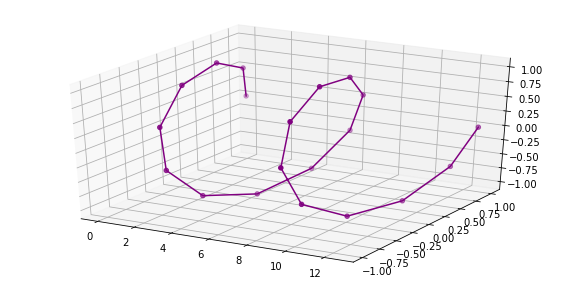

In [13]:
ax = plt.figure( figsize = ( 10, 5 )).add_subplot(111, projection='3d')
ax.plot( coilPoints[:,0], coilPoints[:,1], coilPoints[:,2], 'purple')
ax.scatter( coilPoints[:,0], coilPoints[:,1], coilPoints[:,2], color='purple')
plt.show()

Using this concept we offer the following dataset variations:
1. Helix - two entwined coils, inspired by DNA casing
2. Whirl - an increasingly unwinding Helix 

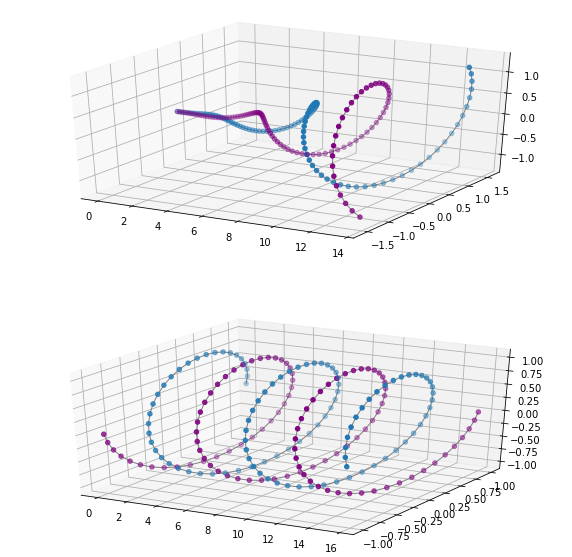

In [17]:
rl.plot_dataset_variants()

# Helix and Whirl Datasets

In [78]:
nBlobPoints = 100
nCoordinates =2
sdevScales = [ .3, .3, .3]
noiseScale = 1/10.
coilDensity = 12
trainTestOverlap = .05

In [79]:
data, labels, t_gen = rl.gen_blob_coils( coilType='whirl', shuffleFlag = False, 
                                         nBlobPoints = nBlobPoints,  
                                         nCoordinates = nCoordinates, 
                                         sdevScales = sdevScales, 
                                         noiseScale = noiseScale, 
                                         coilDensity = coilDensity )

generating blobs; # points = 200
generating blobs; # points = 200
time to generate data on GPU = 0.010989904403686523
	 plotting data - stride = 1 


In [80]:
data, labels, t_gen = rl.gen_blob_coils( coilType='helix', shuffleFlag = False, 
                                         nBlobPoints = nBlobPoints,  
                                         nCoordinates = nCoordinates, 
                                         sdevScales = sdevScales, 
                                         noiseScale = noiseScale, 
                                         coilDensity = coilDensity )

generating blobs; # points = 200
generating blobs; # points = 200
time to generate data on GPU = 0.011035680770874023
	 plotting data - stride = 1 


In [81]:
print(data)


             x         y         z
0     0.364102  0.647071 -0.158519
1     0.364102 -1.352929 -0.158519
2     0.658858  0.814412 -0.445885
3     0.658858 -1.185588 -0.445885
4    -0.630410  1.759064 -0.058172
5    -0.630410 -0.240936 -0.058172
6     0.597037  0.854599 -0.534107
7     0.597037 -1.145401 -0.534107
8    -0.043503  1.206370  0.176017
9    -0.043503 -0.793630  0.176017
10   -0.459140  0.541117  0.913036
11   -0.459140 -1.458883  0.913036
12   -0.450622  0.854530 -0.120225
13   -0.450622 -1.145470 -0.120225
14    0.354997  1.318414  0.346574
15    0.354997 -0.681586  0.346574
16    0.610539  0.738636  0.310431
17    0.610539 -1.261364  0.310431
18    0.940071  1.065538 -0.420519
19    0.940071 -0.934462 -0.420519
20   -0.328584  1.456005  0.066775
21   -0.328584 -0.543995  0.066775
22   -0.165688  0.706643  0.247046
23   -0.165688 -1.293357  0.247046
24   -0.176330  1.621973 -0.030124
25   -0.176330 -0.378027 -0.030124
26   -0.372774  0.230021 -0.657500
27   -0.372774 -1.76

# Split train and test data 

In [82]:
expLog = {}

## RAPIDS Standard Scaler [ Normalize ]

In [83]:
def scale_dataframe_inplace ( targetDF, trainMeans = {}, trainSTDevs = {} ):    
    print('rescaling data')
    sT = time.time()
    for iCol in targetDF.columns:
        
        # omit scaling label column
        if iCol == targetDF.columns[-1] == 'label': continue
            
        # compute means and standard deviations for each column [ should skip for test data ]
        if iCol not in trainMeans.keys() and iCol not in trainSTDevs.keys():            
            trainMeans[iCol] = targetDF[iCol].mean()
            trainSTDevs[iCol] = targetDF[iCol].std()
            
        # apply scaling to each column
        targetDF[iCol] = ( targetDF[iCol] - trainMeans[iCol] ) / ( trainSTDevs[iCol] + 1e-10 )
        
    return trainMeans, trainSTDevs, time.time() - sT

### **CPU** split & scale

In [84]:
# split
trainData_pDF, trainLabels_pDF, testData_pDF, testLabels_pDF, t_split_CPU = rl.split_train_test_nfolds ( data.to_pandas(), labels.to_pandas(), trainTestOverlap = trainTestOverlap )

# apply standard scaling
trainMeans_CPU, trainSTDevs_CPU, t_scaleTrain_CPU = scale_dataframe_inplace ( trainData_pDF )
_,_, t_scaleTest_CPU = scale_dataframe_inplace ( testData_pDF, trainMeans_CPU, trainSTDevs_CPU )    

expLog = rl.update_log( expLog, [['CPU_split_train_test', t_split_CPU],
                                 ['CPU_scale_train_data', t_scaleTrain_CPU], 
                                 ['CPU_scale_test_data', t_scaleTest_CPU]] )

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ CPU_split_train_test     :   0.00325 s ]
 + adding log entry [ CPU_scale_train_data     :   0.15542 s ]
 + adding log entry [ CPU_scale_test_data      :   0.13812 s ]


### **GPU** split & scale

In [85]:
# split
trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, t_split = rl.split_train_test_nfolds ( data, labels, trainTestOverlap = trainTestOverlap )

# apply standard scaling
trainMeans, trainSTDevs, t_scaleTrain = scale_dataframe_inplace ( trainData_cDF )
_,_, t_scaleTest = scale_dataframe_inplace ( testData_cDF, trainMeans, trainSTDevs )    

expLog = rl.update_log( expLog, [['GPU_split_train_test', t_split],
                                 ['GPU_scale_train_data', t_scaleTrain],
                                 ['GPU_scale_test_data', t_scaleTest]] ); 

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ GPU_split_train_test     :   0.07118 s ]
 + adding log entry [ GPU_scale_train_data     :   0.00539 s ]
 + adding log entry [ GPU_scale_test_data      :   0.00581 s ]


In [86]:
# rl.plot_iid_breaking ( trainData_cDF, testData_cDF )

In [87]:
# rl.plot_train_test(trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF)

# Training and Evaluating a Single Model on CPU and GPU

In [88]:
''' -------------------------------------------------------------------------
>  GPU Train and Test
------------------------------------------------------------------------- '''
def train_model_GPU (trainData_cDF, testData_cDF, paramsGPU = {}):    
    print('training xgboost model on GPU');  
    startTime = time.time()    
    
    trainDMatrix = xgboost.DMatrix( trainData_cDF.to_pandas(), label = trainLabels_cDF.to_pandas())    
    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, params = paramsGPU, num_boost_round = paramsGPU['num_boost_rounds'] )
    
    return trainedModelGPU, time.time() - startTime

def test_model_GPU ( trainedModelGPU, testData_cDF, testLabels_cDF ):
    print('testing xgboost model on GPU')
    startTime = time.time()   
    
    testDMatrix = xgboost.DMatrix( data = testData_cDF.to_pandas(), label = testLabels_cDF.to_pandas())    
    predictionsGPU = trainedModelGPU.predict(testDMatrix)
    
    return predictionsGPU, time.time() - startTime

''' -------------------------------------------------------------------------
>  CPU Train and Test
------------------------------------------------------------------------- '''
def train_model_CPU (trainData_cDF, trainLabels_cDF, paramsCPU = {}):    
    print('training xgboost model on {} CPU cores'.format(nCores) )

    startTime = time.time()
    
    trainDMatrix = xgboost.DMatrix( trainData_cDF.to_pandas(), label = trainLabels_cDF.to_pandas())
    
    xgBoostModelCPU = xgboost.train( dtrain = trainDMatrix, params = paramsCPU, num_boost_round = paramsCPU['num_boost_rounds'])
    
    return xgBoostModelCPU, time.time() - startTime

def test_model_CPU ( trainedModelCPU, testData_cDF, testLabels_cDF ):
    print('testing xgboost model on CPU')
    startTime = time.time()
    
    testDMatrix = xgboost.DMatrix( testData_cDF.to_pandas(), label = testLabels_cDF.to_pandas())
    predictionsCPU = trainedModelCPU.predict(testDMatrix)
    
    return predictionsCPU, time.time() - startTime

### Define model parameters
https://xgboost.readthedocs.io/en/latest/parameter.html

In [89]:
nCores = !nproc --all
nCores = int(nCores[0])

paramsCPU = {
    'max_depth': 3,
    'num_boost_rounds': 100,    
    'learning_rate': .1,
    'lambda': 1,    
    'objective': 'binary:hinge',
    'tree_method': 'hist',
    'n_jobs': nCores,
    'random_state': 0
}

paramsGPU = {
    'max_depth': 3,
    'num_boost_rounds': 100,
    'learning_rate': .1,
    'lambda': 1,    
    'objective': 'binary:hinge',
    'tree_method': 'gpu_hist',
    'n_gpus': 1,    
    'random_state': 0
}

### **CPU** Training and Inference

In [90]:
trainedModelCPU, t_trainCPU = train_model_CPU ( trainData_cDF, trainLabels_cDF, paramsCPU )

training xgboost model on 40 CPU cores


In [91]:
predictionsCPU, t_inferCPU = test_model_CPU ( trainedModelCPU, testData_cDF, testLabels_cDF)

testing xgboost model on CPU


In [92]:
expLog = rl.update_log( expLog, [['CPU_model_training', t_trainCPU], ['CPU_model_inference', t_inferCPU]] ); 

 + adding log entry [ CPU_model_training       :   0.11325 s ]
 + adding log entry [ CPU_model_inference      :   0.01728 s ]


### **GPU** Model Training and Inference

In [93]:
trainedModelGPU, t_trainGPU = train_model_GPU ( trainData_cDF, trainLabels_cDF, paramsGPU )

training xgboost model on GPU


In [94]:
predictionsGPU, t_inferGPU = test_model_GPU ( trainedModelGPU, testData_cDF, testLabels_cDF)

testing xgboost model on GPU


In [95]:
expLog = rl.update_log( expLog, [['GPU_model_training', t_trainGPU], ['GPU_model_inference', t_inferGPU]] ); 

 + adding log entry [ GPU_model_training       :   0.14339 s ]
 + adding log entry [ GPU_model_inference      :   0.01161 s ]


### Compare CPU and GPU Accuracy [ plot on train and test ]

In [96]:
trainLabels_pDF = trainLabels_cDF.to_pandas()
testLabels_pDF = testLabels_cDF.to_pandas()

trainPredictionsCPU, _ = test_model_CPU ( trainedModelCPU, trainData_cDF, trainLabels_cDF)
trainPredictionsGPU, _ = test_model_GPU ( trainedModelGPU, trainData_cDF, trainLabels_cDF)
trainAccuracyCPU = accuracy_score(trainLabels_pDF, trainPredictionsCPU)
trainAccuracyGPU = accuracy_score(trainLabels_pDF, trainPredictionsGPU)
print( 'train data CPU accuracy = {}'.format( trainAccuracyCPU ) )
print( 'train data GPU accuracy = {}'.format( trainAccuracyGPU ) )

accuracyCPU = accuracy_score(testLabels_pDF, predictionsCPU)
accuracyGPU = accuracy_score(testLabels_pDF, predictionsGPU)
print( 'test data CPU accuracy = {}'.format( accuracyCPU ) )
print( 'test data GPU accuracy = {}'.format( accuracyGPU ) )

testing xgboost model on CPU
testing xgboost model on GPU
train data CPU accuracy = 1.0
train data GPU accuracy = 1.0
test data CPU accuracy = 0.975
test data GPU accuracy = 0.95


In [97]:
cMat = confusion_matrix(testLabels_pDF, predictionsGPU)
print(cMat)

[[18  1]
 [ 1 20]]


### Visualize the first decision tree

CPU times: user 57.7 ms, sys: 36.7 ms, total: 94.4 ms
Wall time: 199 ms


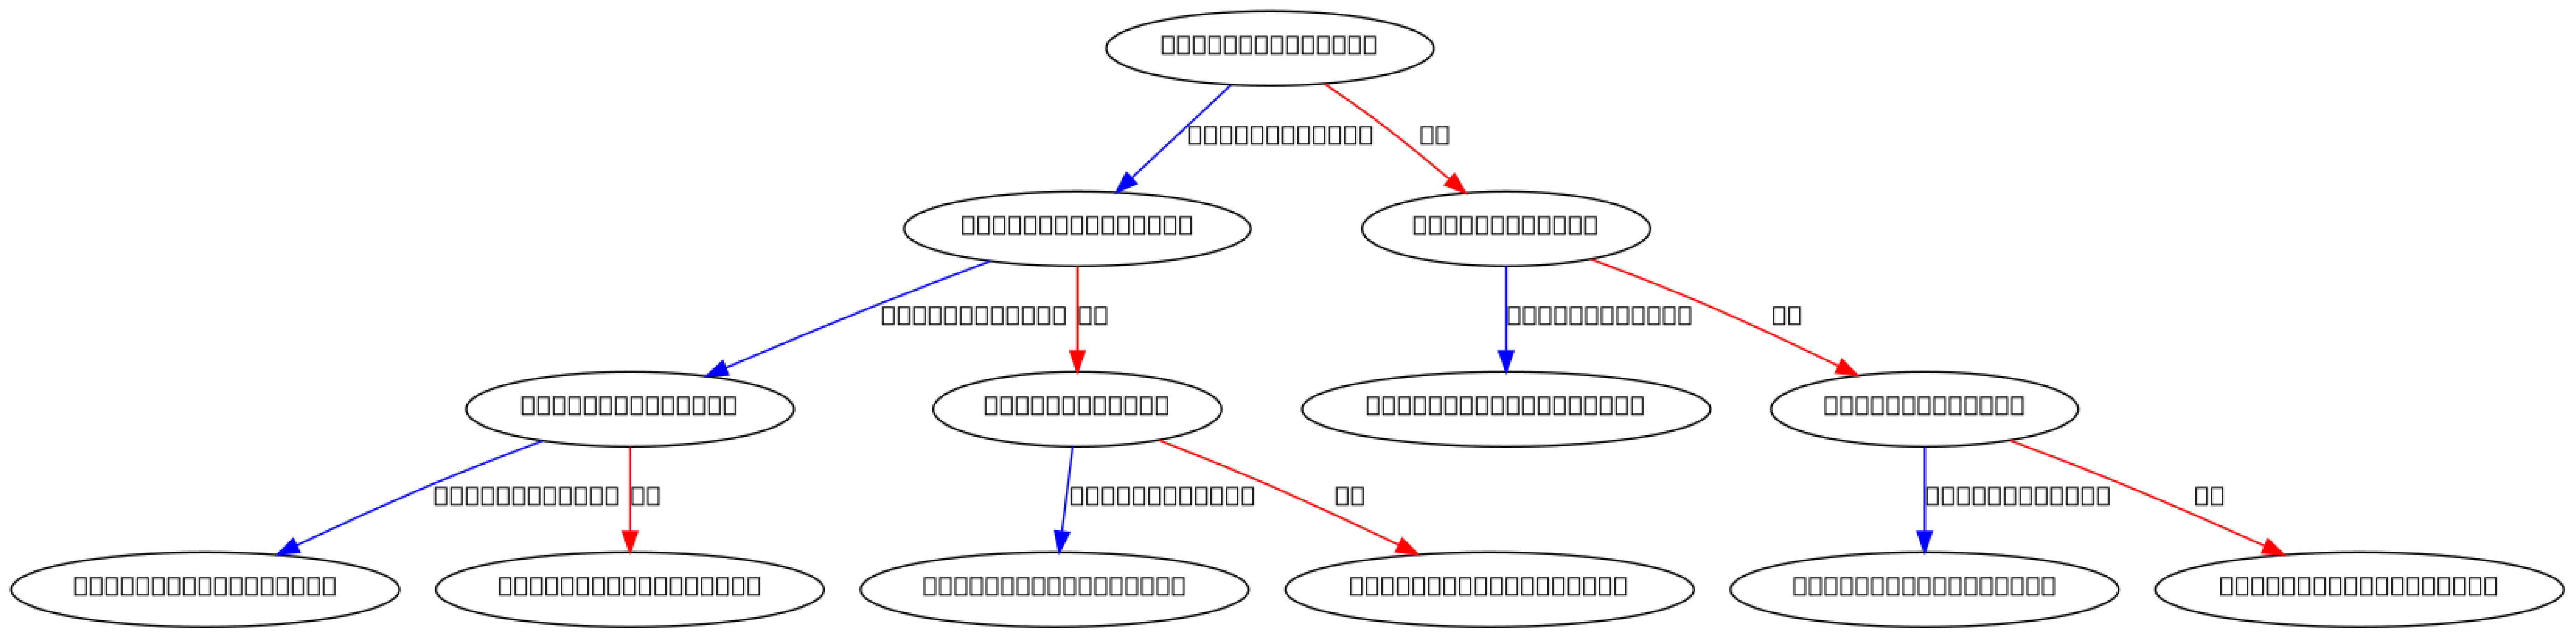

In [98]:
%%time
fig = plt.figure(figsize=(100,50))
plot_tree(trainedModelGPU, num_trees=0, ax=plt.subplot(1,1,1))

In [99]:
expLog

{'CPU_split_train_test': 0.0032491683959960938,
 'CPU_scale_train_data': 0.15541529655456543,
 'CPU_scale_test_data': 0.1381239891052246,
 'GPU_split_train_test': 0.07117724418640137,
 'GPU_scale_train_data': 0.005388498306274414,
 'GPU_scale_test_data': 0.005807399749755859,
 'CPU_model_training': 0.11324644088745117,
 'CPU_model_inference': 0.017277240753173828,
 'GPU_model_training': 0.1433870792388916,
 'GPU_model_inference': 0.011607885360717773}

# Parameter Search          
> TODO: ADD early stopping 

### Initialize Dask

In [100]:
import dask
from dask import delayed
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

In [101]:
import xgboost;
print( xgboost.__version__ )

0.90.rapidsdev1


### Set number of workers [ changes require kernel restart ]

In [102]:
cluster = LocalCUDACluster(ip="", n_workers = 4 )
client = Client(cluster)

In [103]:
client

Client Scheduler: tcp://192.168.99.2:34133 Dashboard: http://192.168.99.2:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


In [104]:
cluster

### Pre-scatter Demo

In [105]:
if client is not None:        
    scatteredData_future = client.scatter( [ trainData_cDF, testData_cDF ], broadcast = True)

In [106]:
scatteredData_future

[<Future: status: finished, type: DataFrame, key: DataFrame-873883dd12956c6f0c0922c25cde267e>,
 <Future: status: finished, type: DataFrame, key: DataFrame-32d1d55fdcbae940349ee541a8e970a5>]

In [107]:
print ( '{} \n {} \n'.format( scatteredData_future[0].key, scatteredData_future[1].key ) )
client.who_has(scatteredData_future)

DataFrame-873883dd12956c6f0c0922c25cde267e 
 DataFrame-32d1d55fdcbae940349ee541a8e970a5 



{'DataFrame-32d1d55fdcbae940349ee541a8e970a5': ('tcp://192.168.99.2:39083',
  'tcp://192.168.99.2:40411',
  'tcp://192.168.99.2:40761',
  'tcp://192.168.99.2:34747'),
 'DataFrame-873883dd12956c6f0c0922c25cde267e': ('tcp://192.168.99.2:39083',
  'tcp://192.168.99.2:40411',
  'tcp://192.168.99.2:40761',
  'tcp://192.168.99.2:34747')}

## HPO Strategy - Particle Swarm [ Explore + Exploit ]

In [108]:
def update_particles( paramRanges, particlesInTimestep, velocitiesInTimestep, bestParamsIndex, globalBestParams, sBest = .85, sExplore = .1 , deltaTime = 1, randomSeed = None):
    
    nParticles = particlesInTimestep.shape[ 0 ]
    nParameters = particlesInTimestep.shape[ 1 ]    
        
    globalBestRepeated = numpy.matlib.repmat( np.array( globalBestParams ).reshape( -1, 1 ), nParticles, 1).reshape( nParticles, nParameters )    
    
    if randomSeed is not None:
        np.random.seed(randomSeed)
        
    # move to best + explore | globalBest + personalBest
    velocitiesInTimestep += 0. * velocitiesInTimestep + sBest * ( globalBestRepeated - particlesInTimestep ) \
                            + sExplore * ( np.random.randn( nParticles, nParameters ) )
    
    particlesInTimestep += velocitiesInTimestep * deltaTime 
    
    # TODO: avoid duplicates
    
    # enforce param bounds
    for iParam in range( nParameters ):
        particlesInTimestep[ :, iParam ] = np.clip(particlesInTimestep[ :, iParam ], paramRanges[iParam][1], paramRanges[iParam][2])
        if paramRanges[iParam][3] == 'int':
            particlesInTimestep[ :, iParam ] = np.round( particlesInTimestep[ :, iParam ] )
            
    return particlesInTimestep, velocitiesInTimestep
    

## HPO Harness
> Particle Evals [ Train and Test Logic ]

In [ ]:
def train_model_hpo ( trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, particleParams, iParticle, iTimestep ):
    
    # fixed parameters
    paramsGPU = { 'objective': 'binary:hinge',
                  'tree_method': 'gpu_hist',
                  'n_gpus': 1,
                  'random_state': 0 }
    
    # parameters to search over
    paramsGPU['max_depth'] = int(particleParams[0])
    paramsGPU['learning_rate'] = particleParams[1]
    paramsGPU['lambda'] = particleParams[2]
    paramsGPU['num_boost_rounds'] = 1000
    
    startTime = time.time()
    trainDMatrix = xgboost.DMatrix( data = trainData_cDF, label = trainLabels_cDF )
    testDMatrix = xgboost.DMatrix( data = testData_cDF, label = testLabels_cDF )
    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, evals = [(testDMatrix, 'test')], 
                                     params = paramsGPU,
                                     num_boost_round = paramsGPU['num_boost_rounds'],
                                     early_stopping_rounds = 15,
                                     verbose_eval = False )
    
    elapsedTime = time.time() - startTime
    
    return trainedModelGPU, elapsedTime

def test_model_hpo ( trainedModelGPU, trainingTime, testData_cDF, testLabels_cDF ):
    
    startTime = time.time()
    
    testDMatrix = xgboost.DMatrix( data = testData_cDF, label = testLabels_cDF )    
    predictionsGPU = trainedModelGPU.predict( testDMatrix ).astype(int)
    
    return predictionsGPU, trainedModelGPU.best_iteration, trainingTime, time.time() - startTime

In [ ]:
def run_hpo ( daskClient, nTimesteps, nParticles, paramRanges, trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, randomSeed = 0, plotFlag = True):
    
    pandasTestLabels = testLabels_cDF.to_pandas()

    if daskClient is not None:
        scatteredData_future = daskClient.scatter( [ trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF ], broadcast = True )
    
    trainData_cDF_future = scatteredData_future[0]; trainLabels_cDF_future = scatteredData_future[1]
    testData_cDF_future = scatteredData_future[2]; testLabels_cDF_future = scatteredData_future[3]
    
    particles, velocities, accuracies, bestParticleIndex, \
        globalBestParticleParams, particleBoostingRounds, particleColors = rl.initialize_particle_swarm ( nTimesteps = nTimesteps, 
                                                                                                          nParticles = nParticles,
                                                                                                          paramRanges = paramRanges,
                                                                                                          randomSeed = randomSeed, 
                                                                                                          plotFlag = plotFlag)
    globalBestAccuracy = 0
    
    trainingTimes = np.zeros (( nTimesteps, nParticles ))    
    startTime = time.time()
    
    predictionHistory = np.zeros((nTimesteps, nParticles, testData_cDF.shape[0]))
    
    for iTimestep in range (0, nTimesteps ):    
        if daskClient is not None:
            # [ delayed ] train xgboost models on train data
            delayedParticleTrain = [ delayed( train_model_hpo )( trainData_cDF_future, trainLabels_cDF_future, 
                                                                     testData_cDF_future, testLabels_cDF_future, 
                                                                     particles[iTimestep, iParticle, : ], 
                                                                         iParticle, iTimestep) for iParticle in range(nParticles) ]

            # [ delayed ] determine number of trees/training-rounds returned early stopping -- used to set particle sizes
            delayedParticleRounds = [ iParticle[0].best_iteration for iParticle in delayedParticleTrain ]
            
            # [delayed ] eval trained models on test/validation data
            delayedParticlePredictions = [ delayed( test_model_hpo )(iParticle[0], iParticle[1], 
                                                                     testData_cDF_future, 
                                                                     testLabels_cDF_future) for iParticle in delayedParticleTrain ]
            
            # execute delayed             
            particlePredictions = dask.compute( delayedParticlePredictions )[0]            
            
            
            for iParticle in range(nParticles):
                predictionHistory[iTimestep, iParticle, :] = particlePredictions[iParticle][0]
            #import pdb; pdb.set_trace()
            
            # compute accuracies of predictions
            accuracies[iTimestep, :] = [ accuracy_score ( pandasTestLabels, iParticle[0]) for iParticle in particlePredictions ]
            particleBoostingRounds[iTimestep, : ] = [ iParticle[1] for iParticle in particlePredictions ]
            trainingTimes[iTimestep, :] = [ iParticle[2] for iParticle in particlePredictions ]
            del particlePredictions
        else:
            for iParticle in range(nParticles):
                trainedModels, _ = train_model_hpo ( pandasTrainData, pandasTrainLabels, particles[iTimestep, iParticle, : ], iParticle, iTimestep)
                predictions, _ = test_model_hpo( trainedModels, pandasTestData, pandasTestLabels)            
                accuracies[iTimestep, iParticle] = accuracy_score (pandasTestLabels, predictions)
        
        bestParticleIndex[iTimestep+1] = np.argmax( accuracies[iTimestep, :] )
        currentBestAccuracy = np.max( accuracies[iTimestep, :] )

        print('@ hpo timestep : {}, best accuracy is {}'.format(iTimestep, np.max(accuracies[iTimestep, :])) )
        if iTimestep +1 < nTimesteps:            
            if currentBestAccuracy > globalBestAccuracy:
                print('\t updating best GLOBAL accuracy')
                globalBestAccuracy = currentBestAccuracy
                globalBestParticleParams[iTimestep+1] = particles[iTimestep, bestParticleIndex[iTimestep+1], :]
            else:
                globalBestParticleParams[iTimestep+1] = globalBestParticleParams[iTimestep].copy()
            
            particles[iTimestep+1, :, :], velocities[iTimestep+1, :, : ] = update_particles ( paramRanges, 
                                                                                              particles[iTimestep, :, :].copy(),
                                                                                              velocities[iTimestep, :, :].copy(), 
                                                                                              bestParticleIndex[iTimestep+1], 
                                                                                              globalBestParticleParams[iTimestep+1], randomSeed = iTimestep)
            

    
    particleSizes = particleBoostingRounds/np.max(particleBoostingRounds)*10 + 2
    
    elapsedTime = time.time() - startTime
    
    bestParamIndex = np.unravel_index(np.argmax(accuracies, axis=None), accuracies.shape)

    # best accuracy
    print('highest accuracy               :  {} '.format(accuracies[bestParamIndex[0], bestParamIndex[1]]))
    print('   @ timestep {}, particle {} '.format( bestParamIndex[0], bestParamIndex[1]))

    print('\nbest model tree depth          :  {} '.format(particles[bestParamIndex[0], bestParamIndex[1], 0]))
    print('best model learning rate       :  {} '.format(particles[bestParamIndex[0], bestParamIndex[1], 1]))
    print('best model regularization      :  {} '.format(particles[bestParamIndex[0], bestParamIndex[1], 2]))
    print('best model num boosting rounds :  {} '.format(int(particleBoostingRounds[bestParamIndex[0], bestParamIndex[1]])))
    
    print( 'elapsed time : {}'.format(elapsedTime) )
    
    return accuracies, particles, velocities, particleSizes, particleColors, bestParticleIndex, bestParamIndex, particleBoostingRounds, trainingTimes, predictionHistory, elapsedTime

## Settings for HPO

In [ ]:
nTimesteps = 10
nParticles = 16

In [ ]:
paramRanges = { 0: ['max_depth', 3, 15, 'int'],
                1: ['learning_rate', .001, 1, 'float'],
                2: ['lambda', 0, 10, 'float'] }

### Run HPO

In [ ]:
accuracies, particles, velocities, particleSizes, particleColors, bestParticleIndex, \
bestParamIndex, particleBoostingRounds, trainingTimes, predictionHistory, elapsedTime = run_hpo ( client, nTimesteps, 
                                                                                                  nParticles,
                                                                                                  paramRanges, 
                                                                                                  trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF )

### Visualize search

In [ ]:
rl.viz_search( accuracies, particleBoostingRounds )

In [ ]:
rl.hpo_animate (particles, particleSizes, particleColors, paramRanges, nTimesteps = nTimesteps )

# Visualize the Prediction Trajectory of the Top Particle [ ending at its best timestep ]

In [ ]:
rl.plot_particle_learning ( nTimesteps, nParticles, testData_pDF, bestParamIndex, predictionHistory )

## Appendix

In [ ]:
# 1 -- use non-synthetic dataset
# 2 -- kubernetes